In [1]:
from phi.torch.flow import *
import numpy as np
import warnings
warnings.filterwarnings("ignore")

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

# Sphere Packing

## 1. Setup

<Figure size 1200x500 with 1 Axes>

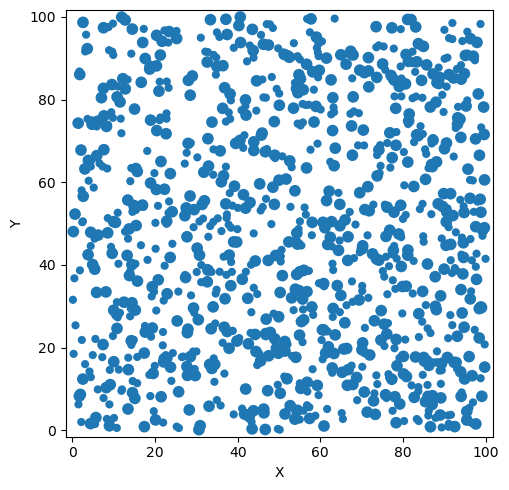

In [2]:
domain_size = 100
num_spheres = 1000
r1 = 0.7
r2 = 1

radii_list = []

#define list of radius (half spheres with R=1 and half R=07)
for i in range(num_spheres // 2):
    radii_list.append(r1)
for i in range(num_spheres // 2):
    radii_list.append(r2)

#define list of random locations
def locate_balls(domain_size):
    location_list = []
    for i in range(num_spheres):
        location_list.append( (math.random_uniform()*domain_size, math.random_uniform()*domain_size) )
    return location_list

location_list = locate_balls(domain_size)

radii = math.stack(radii_list, instance('spheres'))
initial_location = math.stack(location_list, instance('spheres'))

vis.plot(Sphere(x = initial_location[0], y = initial_location[1], radius=radii * math.sqrt(2)), lib='matplotlib')  

# location1 = math.random_uniform(channel(vector='x,y'), instance(spheres=nums_spheres // 2), low=0, high=domain_size)
# location2 = math.random_uniform(channel(vector='x,y'), instance(spheres=nums_spheres // 2), low=0, high=domain_size)
# spheres1 = Sphere(location1, radius=r1)
# spheres2 = Sphere(location2, radius=r2)
# vis.plot(concat(spheres1, spheres2), dim='spheres')

## 2. Energy Function

In [3]:
eps = 1e-10
def energy_function(location):
    # Adjust location to stay within domain boundaries
    location = location - math.floor(location / domain_size) * domain_size
    
    dx = location - math.rename_dims(location, 'spheres', 'others')
    dx = dx + eps * math.ones_like(dx)
    
    dx_r = math.vec_squared(dx + tensor([1,0]) * math.ones_like(dx) * domain_size) ** 0.5 
    dx_l = math.vec_squared(dx + tensor([-1,0]) * math.ones_like(dx) * domain_size) ** 0.5
    
    dx_u = math.vec_squared(dx + tensor([0,1]) * math.ones_like(dx) * domain_size) ** 0.5
    dx_d = math.vec_squared(dx + tensor([0,-1]) * math.ones_like(dx) * domain_size) ** 0.5
    
    dx_ru = math.vec_squared(dx + tensor([1,1]) * math.ones_like(dx) * domain_size) ** 0.5
    dx_lu = math.vec_squared(dx + tensor([-1,1]) * math.ones_like(dx) * domain_size) ** 0.5
    
    dx_rd = math.vec_squared(dx + tensor([1,-1]) * math.ones_like(dx) * domain_size) ** 0.5
    dx_ld = math.vec_squared(dx + tensor([-1,-1]) * math.ones_like(dx) * domain_size) ** 0.5

    dx = math.vec_squared(dx) ** 0.5
    distance = math.min([dx, dx_l, dx_r, dx_u, dx_d, dx_ru, dx_lu, dx_rd, dx_ld],dim='0')
    
    #Computing overlap
    energy = math.maximum(radii + math.rename_dims(radii,'spheres','others') - distance, 0)
    
    distance = math.ones_like(distance) - tensor(np.eye(num_spheres), instance('spheres','others'))
    
    energy *= math.divide_no_nan(energy, distance)
    system_energy = math.sum(energy)
    
    return system_energy

In [4]:
def loss_function(location):
    energy = energy_function(location)
    return math.l2_loss(energy - 0)
    
print(f'Initial Energy: {energy_function(initial_location)}')
print(f'Initial Loss: {loss_function(initial_location)}')

Initial Energy: 445.31964
Initial Loss: 99154.79


In [5]:
learning_rate = 1e-5
max_iterations = 2000

def gradient_descent_optimization(location):
    for i in range(max_iterations):
        gradient_func = math.functional_gradient(loss_function)
        loss, (gradients,) = gradient_func(location)
        if loss.native() < 0.1:
            break
        location  -= learning_rate * gradients
    return location - math.floor(location / domain_size) * domain_size


Final Energy (Gradient Descent): 5.3704166


<Figure size 1200x500 with 1 Axes>

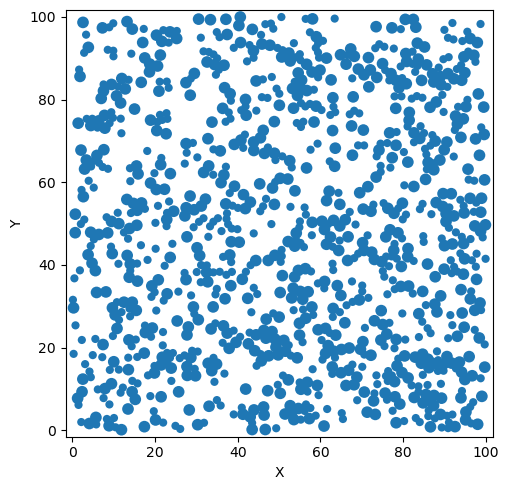

In [6]:
location = initial_location
optimized_location = gradient_descent_optimization(location)
print(f'Final Energy (Gradient Descent): {energy_function(optimized_location)}')

vis.plot(Sphere(x=optimized_location[0], y=optimized_location[1], radius=radii* math.sqrt(2)), lib='matplotlib')

Final Energy (SciPy L-BFGS-B): 3.5461454e-08


<Figure size 1200x500 with 1 Axes>

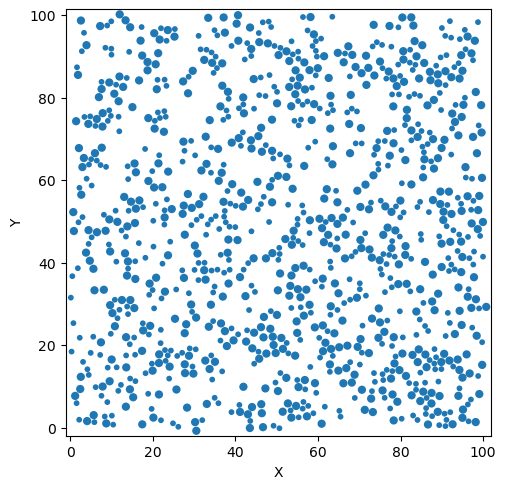

In [7]:
location = initial_location
optimized_location = math.minimize(energy_function, Solve('L-BFGS-B', 0, 1e-5, max_iterations=1000, x0=location))
print(f'Final Energy (SciPy L-BFGS-B): {energy_function(optimized_location)}')

vis.plot(Sphere(x=optimized_location[0], y=optimized_location[1], radius=radii* math.sqrt(2)), lib='matplotlib')

In [13]:
def find_smallest_domain(initial_domain_size):
    domain_size = initial_domain_size
    while True:
        location_list = []
        location_list = locate_balls(domain_size)
        location = math.stack(location_list, instance('spheres'))
        optimized_location = math.minimize(energy_function, Solve('L-BFGS-B', 0, 1e-5, max_iterations=1000, x0=location))
        print(energy_function(optimized_location))
        print(domain_size)
        if energy_function(optimized_location).native() > 0.01:
            break
        domain_size -= 1
    return domain_size

domain_size = 100
smallest_domain_size = find_smallest_domain(domain_size)
print(f'Smallest domain size: {smallest_domain_size}')

0.0
100
1.7763568e-11
99
5.570655e-12
98
1.678302e-10
97
1.0152519e-09
96
1.07149845e-10
95
7.570384e-07
94
0.0
93
5.570655e-12
92
3.6834535e-11
91
2.6110618e-07
90
1.8242758e-09
89
5.570655e-12
88
1.5429862e-09
87
1.1107049e-06
86
1.179989e-06
85
3.5115875e-07
84
1.9936482e-07
83
6.058775e-07
82
8.504259e-09
81
6.429036e-08
80
0.0
79
9.80703e-08
78
9.29067e-08
77
4.839022e-07
76
0.0
75
0.0
74
5.186887e-06
73
1.0524802e-06
72
2.3970392e-07
71
1.3814625e-07
70
1.7856735e-08
69
4.348916e-07
68
4.6087845e-07
67
1.0661264e-06
66
2.953203e-06
65
2.2527868e-06
64
1.2433667e-05
63
1.4737082e-06
62
1.7472287e-06
61
1.029696e-06
60
1.9632926e-06
59
3.6468516e-06
58
2.4451601e-06
57
2.6463674e-06
56
4.6227738e-06
55
4.2198935e-06
54
3.7137818e-06
53
2.7189362e-06
52
3.5799246e-06
51
5.513691e-06
50
4.569146e-06
49
6.006474e-07
48
5.695656e-07
47
1.5406746e-07
46
5.294636e-07
45
3.2945172e-07
44
3.6634674e-07
43
1.1787506e-08
42
5.6807608e-09
41
2.307612e-07
40
9.4268216e-08
39
1.1401111e-05
38
2

KeyboardInterrupt: 

Final Energy (Gradient Descent): 0.002299325


<Figure size 1200x500 with 1 Axes>

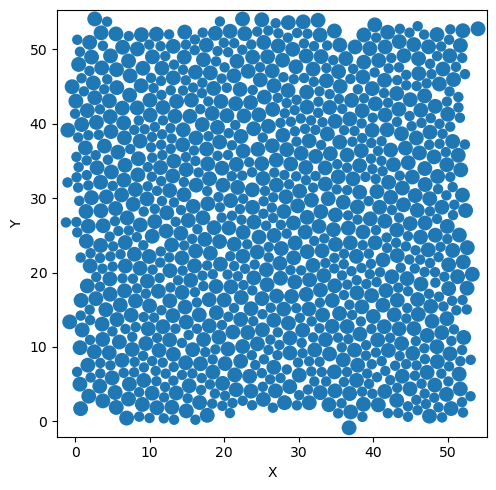

In [14]:
domain_size = 53
location_list = locate_balls(domain_size)
location = math.stack(location_list, instance('spheres'))
optimized_location = math.minimize(energy_function, Solve('L-BFGS-B', 0, 1e-5, max_iterations=1000, x0=location))
print(f'Final Energy (Gradient Descent): {energy_function(optimized_location)}')

vis.plot(Sphere(x=optimized_location[0], y=optimized_location[1], radius=radii), lib='matplotlib')

In [16]:
domain_size = 52
location_list = locate_balls(domain_size)
location = math.stack(location_list, instance('spheres'))
optimized_location = math.minimize(energy_function, Solve('L-BFGS-B', 0, 1e-5, max_iterations=1000, x0=location))
print(f'Final Energy (Gradient Descent): {energy_function(optimized_location)}')

vis.plot(Sphere(x=optimized_location[0], y=optimized_location[1], radius=radii), lib='matplotlib')

NotConverged: ['STOP: TOTAL NO. of ITERATIONS REACHED LIMIT']